<a href="https://colab.research.google.com/github/SJG0510/SJG-ML-Project/blob/main/Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# 📁 Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 📄 엑셀 로드
file_path = '/content/drive/MyDrive/Health/2024년_3-1.부록(시도별)-(1)건강행태.xlsx'
xls_province = pd.ExcelFile(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# 항목별 시트명 매핑
sheet_mapping = {
    '흡연율': '1.현재흡연',
    '음주율': '7.월간음주',
    '비만율': '13.비만율',
    '우울감 경험률': '18.우울감',
    '스트레스 인지율': '17.스트레스'
}

# C12:W199 데이터 추출 함수
def load_original_range(sheet_name):
    df = xls_province.parse(sheet_name, skiprows=11, usecols="C:W", nrows=188)
    df.columns = df.columns.astype(str)
    df['region'] = df['구분'].ffill()
    df['group'] = df['Unnamed: 3'].astype(str).str.strip()
    df['unit'] = df['Unnamed: 4'].astype(str).str.strip()
    return df

# 연도 데이터 추출 함수
def extract_values(df, indicator_name):
    year_cols = [str(y) for y in range(2008, 2025)]
    rows = []
    for _, row in df.iterrows():
        if row['group'] == '전체' and row['unit'] == '(조율)':
            for year in year_cols:
                val = row[year]
                if isinstance(val, str):
                    import re
                    match = re.match(r"([\d\.]+)\(([\d\.]+)\)", val)
                    if match:
                        rows.append({
                            'region': row['region'],
                            'year': int(year),
                            'value': float(match.group(1)),
                            'std': float(match.group(2)),
                            'indicator': indicator_name
                        })
    return pd.DataFrame(rows)

# 🔄 모든 지표 데이터 통합
all_rows = []
for name, sheet in sheet_mapping.items():
    df_sheet = load_original_range(sheet)
    df_extracted = extract_values(df_sheet, name)
    all_rows.append(df_extracted)

df_predict_ready = pd.concat(all_rows, ignore_index=True)


Enter a region name (e.g., 서울, 부산, 경기): 경기


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)



📊 Smoking Rate Forecast for '경기':
----------------------------------------
📅 2025 → 16.53%
📅 2026 → 15.94%
----------------------------------------


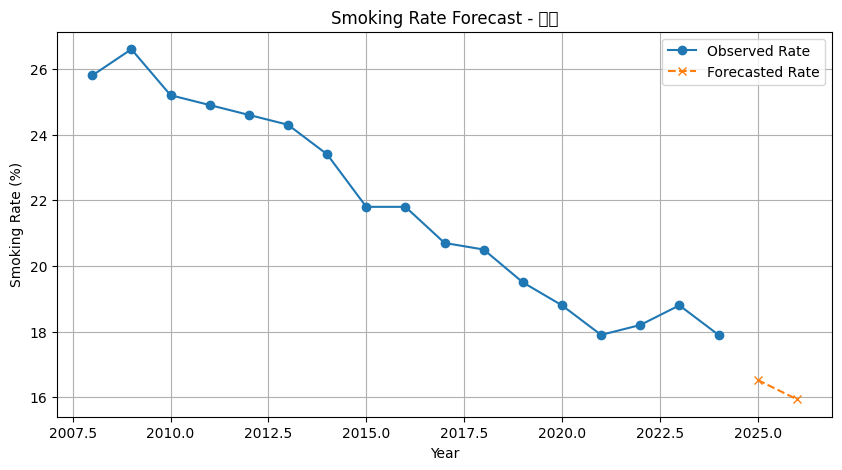

In [19]:
# ✅ 흡연율 전용 예측 함수
def predict_smoking_rate(region_name):
    region_df = df_predict_ready[
        (df_predict_ready['region'] == region_name) &
        (df_predict_ready['indicator'] == '흡연율')
    ]

    if region_df.empty:
        print(f"❌ '{region_name}' not found.")
        return

    X = region_df[['year']]
    y = region_df['value']

    model = LinearRegression()
    model.fit(X, y)

    future_years = np.array([[2025], [2026]])
    future_preds = model.predict(future_years)

    print(f"\n📊 Smoking Rate Forecast for '{region_name}':")
    print("-" * 40)
    for year, pred in zip([2025, 2026], future_preds):
        print(f"📅 {year} → {pred:.2f}%")
    print("-" * 40)

    # 시각화
    plt.figure(figsize=(10, 5))
    plt.plot(X, y, label='Observed Rate', marker='o')
    plt.plot(future_years, future_preds, label='Forecasted Rate', marker='x', linestyle='--')
    plt.title(f'Smoking Rate Forecast - {region_name}')
    plt.xlabel('Year')
    plt.ylabel('Smoking Rate (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

# ▶ 사용자 입력
user_region = input("Enter a region name (e.g., 서울, 부산, 경기): ").strip()
predict_smoking_rate(user_region)